preliminary analysis
281.28491982653304


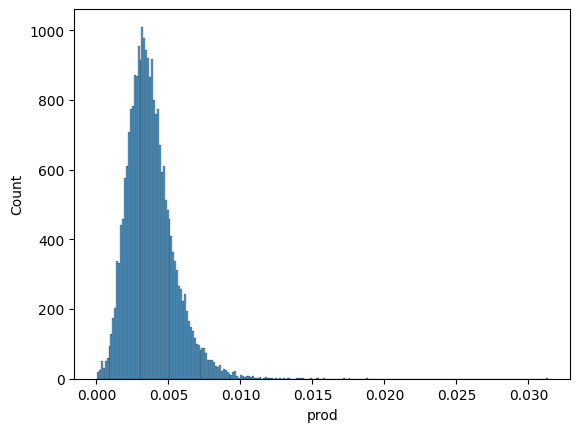

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


print("preliminary analysis")
df = pd.read_excel('data.xlsx')

# Рассчитываем эффективность
df['efficiency'] = (
    df['all_system_fact']-df['break_fact']-df['additional_fact']
) / df['all_system_fact']



df["prod"] = (df["cnt_call"]+ df["cnt_chat"])/(df["dlg_time_call"] + df["dlg_time_chat"])
sns.histplot(df["prod"])
print(1/df["prod"].median())

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)  # Первый квартиль (25%)
    Q3 = df[column].quantile(0.75)  # Третий квартиль (75%)
    IQR = Q3 - Q1                   # Межквартильный размах

    # Определяем границы для выбросов
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Фильтруем данные, оставляя только значения в пределах границ
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return filtered_df

df['id'] = list(range(len(df)))
moscow_df = df[df["residential_city_nm"] == "г Москва"].copy()
df = remove_outliers_iqr(df, 'skill_group_exp')

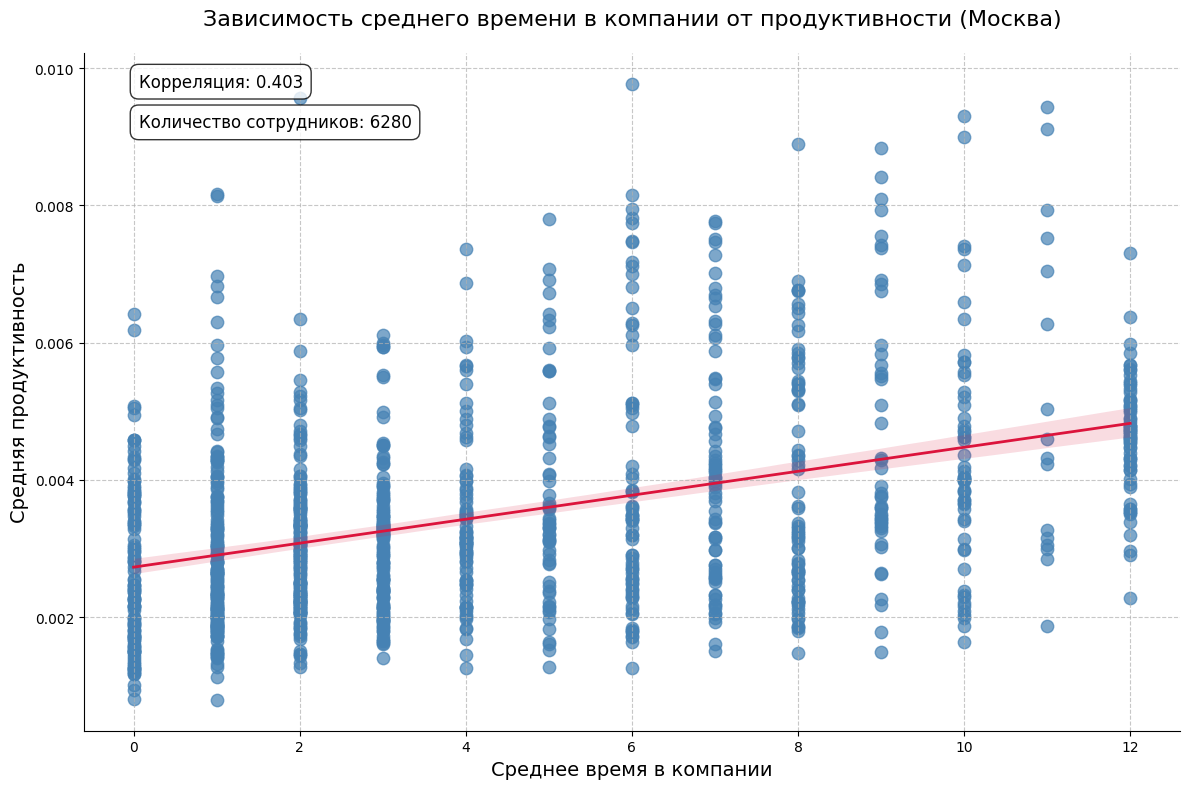

In [3]:
employee_stats = moscow_df.groupby('id').agg({
    'prod': 'median',
    'skill_group_exp': 'median'  # Замените на вашу колонку с временем в компании
}).reset_index()


# Создаем график
plt.figure(figsize=(12, 8))

# Scatter plot с регрессионной линией
sns.regplot(
    data=employee_stats,
    x='skill_group_exp',
    y='prod',  # Замените на вашу колонку
    scatter_kws={
        "alpha": 0.7,
        "s": 80,
        "color": "steelblue"
    },
    line_kws={
        "color": "crimson",
        "lw": 2
    }
)

# Улучшаем внешний вид графика
plt.title('Зависимость среднего времени в компании от продуктивности (Москва)', fontsize=16, pad=20)
plt.ylabel('Средняя продуктивность', fontsize=14)
plt.xlabel('Среднее время в компании', fontsize=14)  # Измените название по необходимости
plt.grid(True, linestyle='--', alpha=0.7)

# Добавляем аннотацию с коэффициентом корреляции
correlation = employee_stats['prod'].corr(employee_stats['skill_group_exp'])
plt.annotate(
    f"Корреляция: {correlation:.3f}",
    xy=(0.05, 0.95),
    xycoords="axes fraction",
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8)
)

# Добавляем информацию о количестве сотрудников
plt.annotate(
    f"Количество сотрудников: {len(employee_stats)}",
    xy=(0.05, 0.89),
    xycoords="axes fraction",
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8)
)

# Настраиваем стиль
sns.despine()
plt.tight_layout()
plt.show()

In [4]:
print(len(moscow_df))
print(moscow_df.head())
print(moscow_df.columns)



6280
    calendar_dt                       id_employee  useful_calls_fact  \
62   2025-01-04  5181d0898e67dc591593ce87ba2bedc0                  0   
69   2024-09-30  b3cc43e687b2c3051e71b1f3228929ff              20442   
90   2024-09-03  61394ec7fe3714c70ebc4104a6b17885              27499   
101  2024-12-26  07c154e0332554d9beee3be5a91da943                  0   
126  2024-09-03  4d57de0823dc982492ad59bb2e6c9aaf                  0   

     useful_chats_fact  avail_calls_fact  avail_chats_fact  \
62               18874                 0              8874   
69                   0              7087                 0   
90                   0                62                 0   
101              18073                 0              2641   
126              14537                 0                 5   

     avail_chat_call_fact  break_fact  education_fact  additional_fact  ...  \
62                      0        4753               0                0  ...   
69                      0      

Mean Squared Error (MSE): 2.0674266055078693e-06
R-squared (R2): 0.14586287754526173


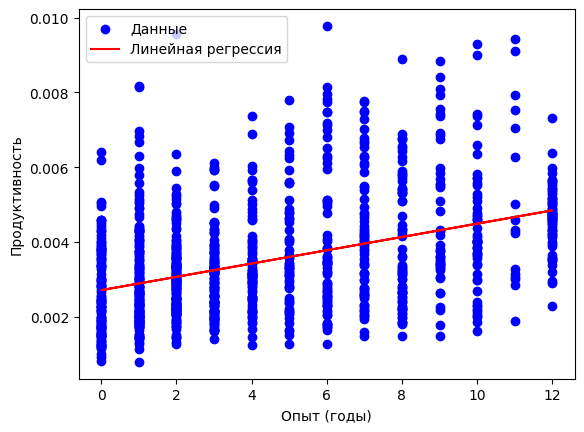

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

df_cleaned = moscow_df.dropna(subset=['skill_group_exp', 'prod'])

X = df_cleaned[['skill_group_exp']]  # Признак: опыт
y = df_cleaned['prod']  # Целевая переменная: продуктивность

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание модели линейной регрессии
model = LinearRegression()

# Обучение модели
model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred = model.predict(X_test)

# Оценка модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

# Визуализация
plt.scatter(X, y, color='blue', label='Данные')
plt.plot(X, model.predict(X), color='red', label='Линейная регрессия')
plt.xlabel('Опыт (годы)')
plt.ylabel('Продуктивность')
plt.legend()
plt.show()

In [6]:
def plot_eff_by_parameter(parameter_column):
    global grouped_data
    """
    Plot average productivity grouped by values of the given parameter column.
    
    Args:
        parameter_column: The column name to group by
    """
    # Skip if the parameter is 'Продуктивность' itself or if it's not a categorical column
    if parameter_column == 'prod' or moscow_df[parameter_column].nunique() > 200:
        return
    
    # Group by the parameter and calculate mean productivity
    grouped_data = moscow_df.groupby(parameter_column)['prod'].agg(['median', 'count']).reset_index()
    
    # Sort by mean productivity for better visualization
    grouped_data = grouped_data.sort_values('median')
    
    # Create figure
    plt.figure(figsize=(12, 6))
    
    # Create bar plot
    print(parameter_column, grouped_data)
    ax = sns.barplot(x=parameter_column, y='median', data=grouped_data)
    
    # Add count annotations
    # for i, row in enumerate(grouped_data.itertuples()):
    #     ax.text(i, row.mean + 0.01, f"n={row.count}", ha='center', va='bottom', fontsize=8)
    
    # Add labels and title
    plt.title(f'Average prod by {parameter_column}', fontsize=14)
    plt.xlabel(parameter_column, fontsize=12)
    plt.ylabel('Average prod', fontsize=12)
    
    # Rotate x-axis labels if needed
    plt.xticks(fontsize=9, rotation=45, ha='right')
    plt.yticks(fontsize=9)
    
    # Add grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

skill_group_exp     skill_group_exp    median  count
0               0.0  0.002414    119
1               1.0  0.002625    164
2               2.0  0.002935    159
3               3.0  0.003027    129
4               4.0  0.003156     84
8               8.0  0.003301     73
5               5.0  0.003364     60
6               6.0  0.003426     73
9               9.0  0.003813     45
7               7.0  0.003963     70
10             10.0  0.004011     56
11             11.0  0.004454     16
12             12.0  0.004695     65


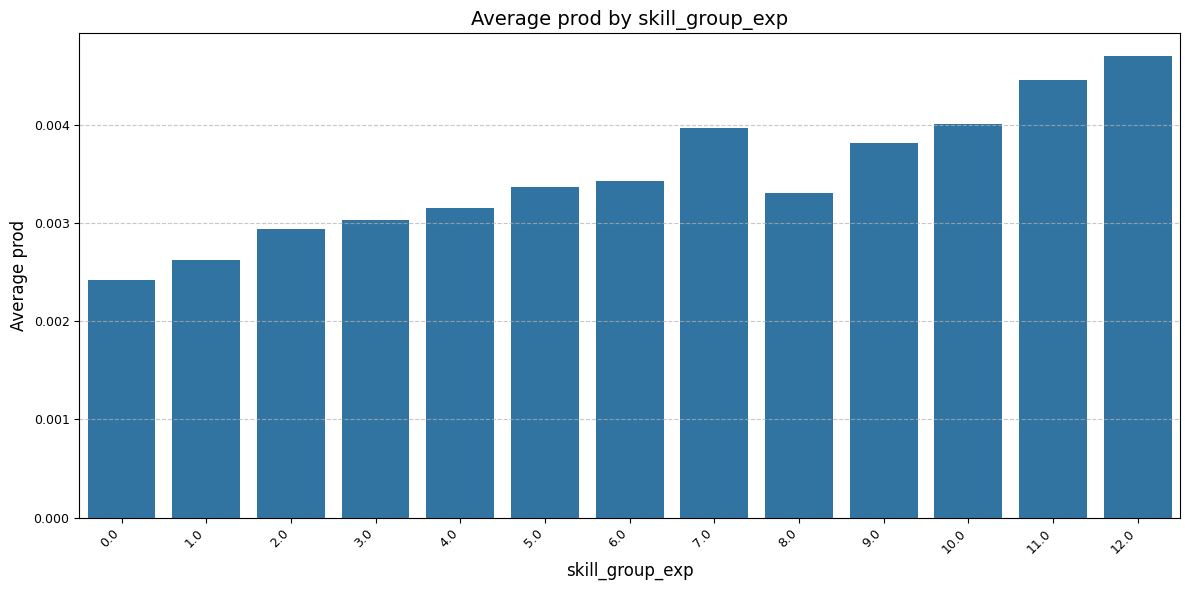

In [7]:
plot_eff_by_parameter('skill_group_exp')

0
                            OLS Regression Results                            
Dep. Variable:                 median   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     67.62
Date:                Sun, 16 Mar 2025   Prob (F-statistic):           3.58e-05
Time:                        02:49:41   Log-Likelihood:                 71.762
No. Observations:                  10   AIC:                            -139.5
Df Residuals:                       8   BIC:                            -138.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0025      0.000   

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


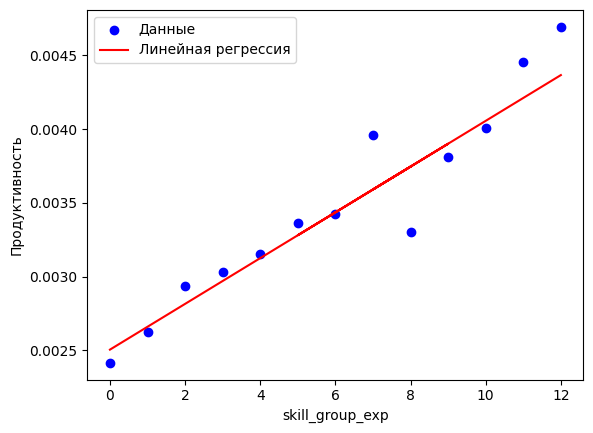

In [11]:
import statsmodels.api as sm

X = grouped_data[['skill_group_exp']]
y = grouped_data['median']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Проверка на NaN в y_train
print(y_train.isnull().sum())

# Добавление константы для модели
X_train_with_const = sm.add_constant(X_train)

# Создание модели
model = sm.OLS(y_train, X_train_with_const).fit()

# Вывод итоговой статистики
print(model.summary())

# Предсказание на тестовых данных
X_test_with_const = sm.add_constant(X_test)
y_pred = model.predict(X_test_with_const)

# Оценка модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

# Визуализация
plt.scatter(X, y, color='blue', label='Данные')
plt.plot(X, model.predict(sm.add_constant(X)), color='red', label='Линейная регрессия')
plt.xlabel('skill_group_exp')
plt.ylabel('Продуктивность')
plt.legend()
plt.show()